<a href="https://colab.research.google.com/github/maiweijie2009/Seattle_airbnb/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business understanding
Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. However, the efficient markets hypothesis and the random walk theory (https://en.wikipedia.org/wiki/Stock_market_prediction) seem to suggest that it is impossible to predict future stock prices by looking at price history. Here I try to build simple machine learning models to see whether it is possible to select stocks in a way better than coin flipping.   

In [43]:
# Install necessary packages and import modules
!pip install pandas-datareader
!pip install yfinance
!pip install ta
# !pip install --upgrade ta
import matplotlib.pyplot as plt
from pandas_datareader import data
import pandas as pd
import numpy as np
# from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import yfinance as yf
from sklearn.model_selection import GridSearchCV
from datetime import datetime


In [44]:
def fill_na(df):
  """fill missing values in the stock dataframe. First forward then backward filling"""
  df = df.fillna(method='ffill').fillna(method='bfill')
  return df

def generate_TS(df,n_step):
  """generate time series from each columns in df. TS size is n_step"""
  df_size = df.shape[0]
  lst = [] # list to hold all time series
  for row in range(df_size-n_step+1):
    for column in df.columns:
      lst.append(df.iloc[row:row+n_step][column].values.tolist())

  return pd.DataFrame(lst)

# Data understaning

In [45]:
tickers = ['AAPL', 'MSFT', 'SPY','GOOGL','AMZN','PFE','AAL','DAL','TSLA','NFLX','UBER','LRCX','ADBE','JMIA','RKT','BIDU','QS','BABA','GM','INSM']
period = '10y' # period of historic stock data

data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = False,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  20 of 20 completed


In [46]:
# remove the last row if its timestamp is the same as present day
current_date = pd.Timestamp(datetime.now().date())
if data.index[-1]==current_date:
  data = data.iloc[:-1]
data.tail()

LRCX              ...       UBER            
                  Open        High  ...  Adj Close      Volume
Date                                ...                       
2020-12-22  479.429993  481.739990  ...  53.779999  23871800.0
2020-12-23  479.619995  480.790009  ...  53.709999  12671100.0
2020-12-24  473.679993  480.339996  ...  52.880001   6316800.0
2020-12-28  485.579987  487.429993  ...  51.970001  12059000.0
2020-12-29  475.660004  477.019989  ...  52.270000  10135000.0

[5 rows x 120 columns]

In [5]:
# create a dataframe that only contains the Adj Close for all stocks
df = pd.DataFrame()
for ticker in tickers:
  df_temp = data[ticker]['Adj Close'].rename(ticker)
  df = pd.concat([df,df_temp],axis=1) # combine stocks
df = fill_na(df) # fill NAN in the dataframe
df.tail()

,AAPL,MSFT,SPY,GOOGL,AMZN,PFE,AAL,DAL,TSLA,NFLX,UBER,LRCX,ADBE,JMIA,RKT,BIDU,QS,BABA,GM,INSM
2020-12-22 00:00:00,131.880005,223.940002,367.239990,1720.219971,3206.520020,36.740002,15.480000,38.939999,640.340027,527.330017,53.779999,476.950012,504.170013,47.669998,21.700001,191.259995,131.669998,255.830002,40.900002,35.980000
2020-12-23 00:00:00,130.960007,221.020004,367.570007,1728.229980,3185.270020,37.439999,15.890000,40.240002,645.979980,514.479980,53.709999,471.130005,496.910004,46.439999,21.650000,193.360001,110.790001,256.179993,42.450001,35.450001
2020-12-24 00:00:00,131.970001,222.750000,369.000000,1734.160034,3172.689941,37.270000,15.660000,39.730000,661.770020,513.969971,52.880001,480.339996,499.859985,43.619999,20.830000,191.020004,114.769997,222.000000,41.580002,35.410000
2020-12-28 00:00:00,136.690002,224.960007,372.170013,1773.959961,3283.959961,36.820000,16.059999,40.150002,663.690002,519.119995,51.970001,476.100006,498.950012,40.360001,20.500000,193.080002,115.199997,222.360001,41.660000,34.099998
2020-12-29 00:00:00,134.869995,224.149994,371.459991,1757.760010,3322.000000,37.049999,15.860000,40.029999,665.989990,530.869995,52.270000,473.220001,502.109985,39.919998,20.750000,195.070007,101.000000,236.259995,41.570000,33.500000


In [6]:
# Daily relative returns
returns = df.pct_change(1)
returns.dropna(inplace=True)
returns.head()

,AAPL,MSFT,SPY,GOOGL,AMZN,PFE,AAL,DAL,TSLA,NFLX,UBER,LRCX,ADBE,JMIA,RKT,BIDU,QS,BABA,GM,INSM
2010-12-31 00:00:00,-0.003399,0.002154,0.000239,-0.008166,-0.015048,0.001144,-0.011846,0.008807,0.004906,-0.022803,0.0,-0.011832,0.006870,0.0,0.0,-0.017106,0.0,0.0,0.001086,0.000000
2011-01-03 00:00:00,0.021733,0.002508,0.010338,0.017476,0.023444,0.009709,0.063936,-0.001587,-0.000376,0.015424,0.0,-0.035728,0.016569,0.0,0.0,0.033150,0.0,0.0,0.005426,0.015873
2011-01-04 00:00:00,0.005219,0.003931,-0.000551,-0.003690,0.004288,0.017534,-0.002817,-0.003975,0.001878,0.016591,0.0,-0.010414,0.007031,0.0,0.0,0.012434,0.0,0.0,0.022666,0.031250
2011-01-05 00:00:00,0.008180,-0.003204,0.005198,0.011543,0.013026,0.006671,0.045198,0.035914,0.005999,-0.009042,0.0,-0.043514,0.022533,0.0,0.0,0.036248,0.0,0.0,0.004485,-0.015152
2011-01-06 00:00:00,-0.000809,0.029286,-0.001959,0.007273,-0.008324,0.003865,0.012613,-0.005393,0.039135,-0.009681,0.0,0.000635,0.001552,0.0,0.0,0.005066,0.0,0.0,0.021802,0.015385


In [7]:
# Daily log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(df).diff()
log_returns.head()

,AAPL,MSFT,SPY,GOOGL,AMZN,PFE,AAL,DAL,TSLA,NFLX,UBER,LRCX,ADBE,JMIA,RKT,BIDU,QS,BABA,GM,INSM
2010-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-31 00:00:00,-0.003405,0.002152,0.000239,-0.008199,-0.015162,0.001143,-0.011916,0.008769,0.004894,-0.023067,0.0,-0.011903,0.006846,0.0,0.0,-0.017254,0.0,0.0,0.001086,0.000000
2011-01-03 00:00:00,0.021500,0.002505,0.010285,0.017325,0.023174,0.009662,0.061975,-0.001589,-0.000376,0.015306,0.0,-0.036382,0.016433,0.0,0.0,0.032613,0.0,0.0,0.005411,0.015748
2011-01-04 00:00:00,0.005206,0.003924,-0.000551,-0.003697,0.004279,0.017382,-0.002821,-0.003983,0.001877,0.016455,0.0,-0.010469,0.007006,0.0,0.0,0.012357,0.0,0.0,0.022413,0.030772
2011-01-05 00:00:00,0.008147,-0.003209,0.005184,0.011476,0.012942,0.006648,0.044206,0.035284,0.005981,-0.009083,0.0,-0.044489,0.022282,0.0,0.0,0.035607,0.0,0.0,0.004475,-0.015267


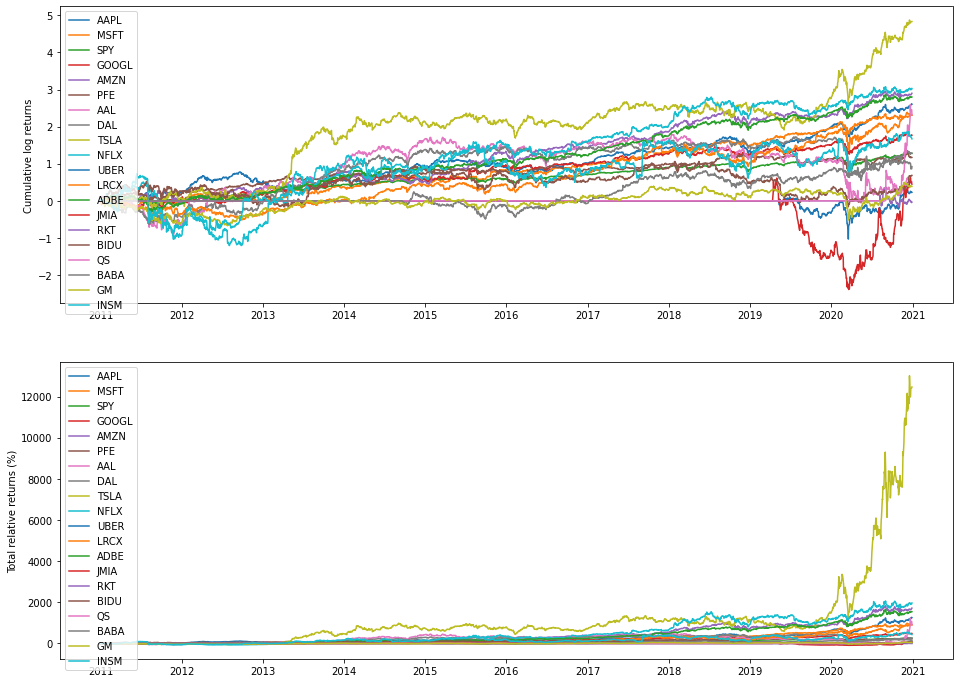

In [8]:
# plot cumulative log returns of total relative returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()

All stock show an increasing trend over a period of 10 years. Most of the selected stock seem to have outperformed S&P 500 in this 10-years period.

# Classifier with extracted features
Use extracted features to predict whether the price will increase or decrease in "shift" days later, instead of dicretly predicting the price. 

In [9]:
def feature_extraction_pct_chnage(df,shift = 1):
  """input: df, stock price data
  shift: how many days price change are used to  predict buy or sell
  Return: df with more features based on the data"""
  stock_df = df.copy()

  # create the high-low column
  stock_df['H_L'] = stock_df['High']-stock_df['Low']
  # create the close-open column
  stock_df['C_O'] = stock_df['Close']-stock_df['Open']
  # create the 7 day moving average
  stock_df['7d_MA'] = stock_df['Close'].rolling(7).mean()
  # create the 7 day moving average
  stock_df['14d_MA'] = stock_df['Close'].rolling(14).mean()
  # create the 21 day moving average
  stock_df['21d_MA'] = stock_df['Close'].rolling(21).mean()
  # create the 7 day standard deviation
  stock_df['7d_std'] = stock_df['Close'].rolling(7).std()  
  # create 7d moving average of volume
  stock_df['7d_V_MA'] = stock_df['Volume'].rolling(7).mean()
  # create 7d std of volume
  stock_df['7d_V_std'] = stock_df['Volume'].rolling(7).std()
  # create the columns of daily price change
  stock_df['pct_change_1'] = stock_df['Close'].pct_change(periods=1)

  if shift>1:
    for i in np.arange(2,shift+1):
      stock_df['pct_change_'+str(i)] = stock_df['pct_change_1'].shift(-i+1)
  
  # drop na generated due to the data processing
  stock_df.dropna(inplace=True)
  
  stock_df['Buy'] = ((stock_df.iloc[:,-shift:]>0).sum(axis=1))==shift

  return stock_df

In [10]:
# create the training set, validataion set and test set.
# about 90% training,and 10% testing
# Training set: data before 2020
# Test set: data in 2020
df_train = pd.DataFrame()
df_test = pd.DataFrame()
shift = 2

feature_cols = ['H_L','C_O','7d_MA', '14d_MA','21d_MA','7d_std','7d_V_MA','7d_V_std','Buy']# features used for modeling, the last one is output

for ticker in tickers:
  stock_df = feature_extraction_pct_chnage(data[ticker],shift)[feature_cols]
  df_train = pd.concat([df_train,stock_df[stock_df.index<'2020']])
  df_test = pd.concat([df_test,stock_df[stock_df.index>='2020']])

# shuffle
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
Y_train = df_train.iloc[:,-1] # true if the daily price change is predicted to increaes for "shift" days
X_test = df_test.iloc[:,:-1]
Y_test = df_test.iloc[:,-1] # true if the daily price change is predicted to increaes for "shift" days

In [11]:
# # train a ensemble classifier with refinement
# clf_ensemble_instance = RandomForestClassifier(max_depth=15)
# # define paramter space used the grid search of model hyperparameters
# param_grid = { 
#     'n_estimators': [100,200,300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [2,4,8,None],
#     'class_weight': ['balanced','balanced_subsample']
# }
# clf_ensemble = GridSearchCV(estimator=clf_ensemble_instance, param_grid=param_grid, cv= 5)
# clf_ensemble.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [12]:
# hyper_paras = clf_ensemble.best_params_ # store hyperparameters of the optimized model
# print(classification_report(Y_train, clf_ensemble.predict(X_train))) # prediction report of training set
# print(classification_report(Y_test, clf_ensemble.predict(X_test))) # prediction report of testing set
# print('Best parameters found:\n', clf_ensemble.best_params_) # print the best model hyperparameters

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     26009
        True       1.00      1.00      1.00      9296

    accuracy                           1.00     35305
   macro avg       1.00      1.00      1.00     35305
weighted avg       1.00      1.00      1.00     35305

              precision    recall  f1-score   support

       False       0.75      0.93      0.83      3433
        True       0.40      0.13      0.19      1220

    accuracy                           0.72      4653
   macro avg       0.57      0.53      0.51      4653
weighted avg       0.66      0.72      0.66      4653

Best parameters found:
 {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}


For the training set, the model is 91% accurate on predicting whether the stock is increasing or decreasing the next day. For the validataion set, the accuracy is 80%, which is much better than the accuracy of a random walk (50%). Moreover, the precision of a "True" prediction is 83%, meaning that when the model predicts a stock to increase, it is 83% accurate.

The enemble classifier allows outputing the probability of each class. Everyday, an investor can use the model to predict whether a stock is going up and going down, and only purchase the stocks of high probability of going up (without considering selling short). 

One can also increase the value of "margin" to only select stocks with high probability of significant price increase.

In [13]:
# # After testing, all data is used to train a new model
# df_all = pd.concat([df_test,df_train])
# X_all = df_all.iloc[:,:-1]
# Y_all = df_all.iloc[:,-1]

# clf_ensemble = RandomForestClassifier(**clf_ensemble.best_params_)
# clf_ensemble.fit(X_all,Y_all)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
# # make prediction of all stocks of interst, with class probability 
# predict_list = []
# stocks = []
# for ticker in tickers:
#   stocks.append(ticker)
#   df_interest = feature_extraction_pct_chnage(data[ticker],shift)[feature_cols]
#   X_interest = df_interest.iloc[-1,:-1]
#   predict_list.append(clf_ensemble.predict_proba(X_interest.values.reshape(1, -1))[0].tolist())
#   # print('Stock price of {} increase?: {} {}'.format(stock, clf_ensemble.predict(X_interest.values.reshape(1, -1))[0],clf_ensemble.predict_proba(X_interest.values.reshape(1, -1))))# print prediction

# predict_df = pd.DataFrame(predict_list,columns=['Sell','Buy'])
# predict_df['Stock'] = stocks
# predict_df = predict_df[['Stock','Sell','Buy']].sort_values(by='Buy',ascending=False)

In [15]:
# predict_df

,Stock,Sell,Buy
9,NFLX,0.173333,0.826667
4,AMZN,0.196667,0.803333
17,BABA,0.220000,0.780000
15,BIDU,0.253333,0.746667
8,TSLA,0.333333,0.666667
0,AAPL,0.806667,0.193333
2,SPY,0.826667,0.173333
1,MSFT,0.853333,0.146667
3,GOOGL,0.860000,0.140000
6,AAL,0.883333,0.116667


# New model using technical indicators

In [170]:
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.volume import EaseOfMovementIndicator

df_w_feature_dict = {}
period = '10y'
shift = 2

# get indictors of each stock
for ticker in tickers:
  stock = yf.Ticker(ticker)
  # get historical market data
  df = stock.history(period=period)
  # Initialize Bollinger Bands Indicator
  indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)
  # Add Bollinger Bands features
  df['bb_bbm'] = indicator_bb.bollinger_mavg()
  df['bb_bbh'] = indicator_bb.bollinger_hband()
  df['bb_bbl'] = indicator_bb.bollinger_lband()

  # Add Bollinger Band high indicator
  df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

  # Add Bollinger Band low indicator
  df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

  # add RSI indicator
  indicator_RSI = RSIIndicator(close=df["Close"])
  df['RSI'] = indicator_RSI.rsi()

  # add Ease of movement indicator
  EOM = EaseOfMovementIndicator(high = df['High'],low = df['Low'],volume=df['Volume'])
  df['EOM'] = EOM.ease_of_movement()
  df['EOM_signal'] = EOM.sma_ease_of_movement()

  # create label for prediction
  df['pct_change_1'] = df['Close'].pct_change(periods=1)

  if shift>1:
    for i in np.arange(2,shift+1):
      df['pct_change_'+str(i)] = df['pct_change_1'].shift(-i+1)
  
  df['Buy'] = ((df.iloc[:,-shift:]>0).sum(axis=1))==shift

  # concat df of all stocks
  df_w_feature_dict[ticker] = df

# concat all dataframe to get one dataframe
df_w_feature = pd.concat([df_w_feature_dict[ticker] for ticker in tickers], axis=1, keys=tickers)
# can not drop na over the entire dataframe, as different stocks have different IPO time
if df_w_feature.index[-1]==current_date:
  df_w_feature = df_w_feature.iloc[:-1]
df_w_feature.tail()


AAPL                          ...         INSM                    
                  Open        High         Low  ... pct_change_1 pct_change_2    Buy
Date                                            ...                                 
2020-12-22  131.610001  134.410004  129.649994  ...    -0.025724    -0.014730  False
2020-12-23  132.160004  132.429993  130.779999  ...    -0.014730    -0.001128  False
2020-12-24  131.320007  133.460007  131.100006  ...    -0.001128    -0.036995  False
2020-12-28  133.990005  137.339996  133.509995  ...    -0.036995    -0.017595  False
2020-12-29  138.050003  138.789993  134.339996  ...    -0.017595     0.008955  False

[5 rows x 360 columns]

In [171]:
X_all = pd.DataFrame()
Y_all = pd.DataFrame()
# create dataset for model training and tesing
for ticker in tickers:
  df = df_w_feature[ticker]
  df = df.dropna() # drop na
  X_all = pd.concat([X_all,df.iloc[:,7:-1]])
  Y_all = pd.concat([Y_all,df.iloc[:,-1]])

Y_all = Y_all.astype('int')

In [172]:
# train test split
X_train = X_all[X_all.index<'2020']
X_test = X_all[X_all.index>='2020']
Y_train = Y_all[Y_all.index<'2020']
Y_test = Y_all[Y_all.index>='2020']

In [173]:
# train a ensemble classifier with refinement
clf_ensemble_instance = RandomForestClassifier(max_depth=15)
# define paramter space used the grid search of model hyperparameters
param_grid = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,8,None],
    'class_weight': ['balanced','balanced_subsample']
}
clf_ensemble = GridSearchCV(estimator=clf_ensemble_instance, param_grid=param_grid, cv= 5)
clf_ensemble.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [174]:
hyper_paras = clf_ensemble.best_params_ # store hyperparameters of the optimized model
print(classification_report(Y_train, clf_ensemble.predict(X_train))) # prediction report of training set
print(classification_report(Y_test, clf_ensemble.predict(X_test))) # prediction report of testing set
print('Best parameters found:\n', clf_ensemble.best_params_) # print the best model hyperparameters

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25974
           1       1.00      1.00      1.00      9349

    accuracy                           1.00     35323
   macro avg       1.00      1.00      1.00     35323
weighted avg       1.00      1.00      1.00     35323

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3450
           1       1.00      1.00      1.00      1225

    accuracy                           1.00      4675
   macro avg       1.00      1.00      1.00      4675
weighted avg       1.00      1.00      1.00      4675

Best parameters found:
 {'class_weight': 'balanced_subsample', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}


In [177]:
# make prediction of all stocks of interst, with class probability 
predict_list = []
stocks = []
for ticker in tickers:
  stocks.append(ticker)
  X_interest = df_w_feature[ticker].iloc[-1,7:-1]
  predict_list.append(clf_ensemble.predict_proba(X_interest.values.reshape(1, -1))[0].tolist())
  # print('Stock price of {} increase?: {} {}'.format(stock, clf_ensemble.predict(X_interest.values.reshape(1, -1))[0],clf_ensemble.predict_proba(X_interest.values.reshape(1, -1))))# print prediction

predict_df = pd.DataFrame(predict_list,columns=['Sell','Buy'])
predict_df['Stock'] = stocks
predict_df = predict_df[['Stock','Sell','Buy']].sort_values(by='Buy',ascending=False)

In [176]:
predict_df

,Stock,Sell,Buy
15,BIDU,0.238691,0.761309
17,BABA,0.264961,0.735039
8,TSLA,0.339674,0.660326
10,UBER,0.344469,0.655531
14,RKT,0.364060,0.635940
2,SPY,0.597450,0.402550
4,AMZN,0.611460,0.388540
9,NFLX,0.618332,0.381668
12,ADBE,0.618990,0.381010
5,PFE,0.664498,0.335502
